# Predicting Loan Default

We build a classifier to predict the probability of default for a given loan. We use loan data obtained by Lending Club from 2007-2017 which can be found on Kaggle.

## Packages

In [1]:
## data handling 
import numpy as np 
import pandas as pd
import polars as pl 
import polars.selectors as cs

## tuning
import optuna 

## visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px

## sklearn models
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

## for saving the model 
from pickle import dump, load

## get file path of the data
from private import FILE_PATH

## Data

In [2]:
## load file
loans = pl.read_csv(FILE_PATH, ignore_errors=True)

## drop those that have null id 
loans = loans.drop_nulls(subset=["id"])

In [3]:
## view the table 
loans.glimpse(max_items_per_column=3, max_colname_length=20)

Rows: 2260668
Columns: 151
$ id                   <i64> 68407277, 68355089, 68341763
$ member_id            <str> None, None, None
$ loan_amnt            <f64> 3600.0, 24700.0, 20000.0
$ funded_amnt          <f64> 3600.0, 24700.0, 20000.0
$ funded_amnt_inv      <f64> 3600.0, 24700.0, 20000.0
$ term                 <str> ' 36 months', ' 36 months', ' 60 months'
$ int_rate             <f64> 13.99, 11.99, 10.78
$ installment          <f64> 123.03, 820.28, 432.66
$ grade                <str> 'C', 'C', 'B'
$ sub_grade            <str> 'C4', 'C1', 'B4'
$ emp_title            <str> 'leadman', 'Engineer', 'truck driver'
$ emp_length           <str> '10+ years', '10+ years', '10+ years'
$ home_ownership       <str> 'MORTGAGE', 'MORTGAGE', 'MORTGAGE'
$ annual_inc           <f64> 55000.0, 65000.0, 63000.0
$ verification_status  <str> 'Not Verified', 'Not Verified', 'Not Verified'
$ issue_d              <str> 'Dec-2015', 'Dec-2015', 'Dec-2015'
$ loan_status          <str> 'Fully Paid', 'Fully Paid

## Cleaning and Feature Elimination

In this section we will perform significant cleaning on the data, including feature elimination of most variables. 

### Getting the Default Column 

Since we want to predict default, we have to look at the `loan_status` column. In this column, we use `Charged Off` as our proxy for default. We will encode each of these as a `1` in the new default column. Of the remaining rows, only those that are `Fully Paid` will be called `0`. Everything else will be dropped. 

In [4]:
loans_df = (
    loans.with_columns(
        (pl.col("loan_status") == "Charged Off")
        .map_elements(np.uint8).alias("default")
    )
)

# filter 
loans_df = (
    loans_df.filter(
        (pl.col("loan_status") == "Fully Paid") | 
        (pl.col("loan_status") == "Charged Off")
    )
)

# drop loan status 
loans_df = loans_df.drop("loan_status")

### Feature Elimination

Given the large number of features, we will perform significant feature elimination. We use the following methodology: 

1. Eliminate features with more that 25% missing values. 
1. Eliminate features that appear to be irrelevant to default.

In [5]:
## eliminate features with more than 25% missing
null_fractions = (loans_df.null_count() / loans_df.shape[0]) > 0.25
drop_list = [col.name for col in loans_df.iter_columns() 
             if null_fractions[0,col.name] == True]
loans_df = loans_df.drop(drop_list)

We keep features which contain relevant credit detail of a lender, including income, credit scores, debt-to-income ratio. We also keep features which are available to investors when considering an investment in the loan, such as interest rate, loan grade, home ownership, employment. Basically, we pick features that would be commonly found on a loan application and would be submitted by the borrower. 

In [6]:
keep_list = [
 'id', 'loan_amnt', 'term', 'int_rate', 'installment',
 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership',
 'annual_inc', 'verification_status', 'purpose', 'title', 'annual_inc',
 'last_pymnt_amnt', 'num_actv_rev_tl', 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_old_rev_tl_op', 'avg_cur_bal', 'acc_open_past_24mths', 'zip_code',
 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'fico_range_low',
 'fico_range_high', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies',
 'initial_list_status', 'revol_bal', 'revol_util', 'total_acc', 
 'bc_open_to_buy', 'bc_util', 'default'
]

drop_list = [col.name for col in loans_df.iter_columns() 
             if col.name not in keep_list]

loans_df = loans_df.drop(drop_list)

loans_df.shape

(1345310, 37)

We have been able to reduce the number of features to 37. 

## EDA and Feature Selection

In this section, we perform EDA on the reduced dataset and use our analysis to further trim the features in our model. 

### Categorical Variables 

We first look at the categorical variables: `grade`, `subgrade`, `emp_title`, `emp_length`, `home_ownership`, `verification_status`, `purpose`, `title`, `zip_code`, `addr_state`, `earliest_cr_line`, `initial_list_status`. 

In [7]:
cat_vars = loans_df.select(~cs.by_dtype(pl.NUMERIC_DTYPES)).columns

## note to_pandas requires pyarrow
loans_df[cat_vars].to_pandas().describe(include='all').T

,count,unique,top,freq
term,1345310,2,36 months,1020743
grade,1345310,7,B,392741
sub_grade,1345310,35,C1,85494
emp_title,1259525,378353,Teacher,21268
emp_length,1266799,11,10+ years,442199
home_ownership,1345310,6,MORTGAGE,665579
verification_status,1345310,3,Source Verified,521273
purpose,1345310,14,debt_consolidation,780321
title,1328651,61682,Debt consolidation,660960
zip_code,1345309,943,945xx,15005


As we can see, `emp_title`, `title`, `zip_code`, and `earliest_cr_line` all have many unique values (> 100). While these features may be useful, they are too granular for us to consider. We will therefore drop these features from our dataset. 

For further work, a sentiment analysis of the `emp_title` and `title` could be useful. Also, since geography is a useful metric, we will instead use `addr_state` as a more general feature of this. 

In [8]:
loans_df = loans_df.drop(["emp_title", "title", "zip_code", "earliest_cr_line"])
cat_vars = loans_df.select(~cs.by_dtype(pl.NUMERIC_DTYPES)).columns

Let's look at the other variables. First we fix some variables. 

In [9]:
## fix term column
loans_df = loans_df.with_columns(
    pl.col("term").map_elements(lambda s: np.int8(s.split()[0])).alias("term")
)

## fix emp_length column
mp = {
    "10+ years" : "10 years",
    "< 1 year" : "0 years"
}    
loans_df = loans_df.with_columns(
    (pl.col("emp_length").replace(mp, default=pl.col("emp_length"))
     .alias("emp_length"))
)

def to_int(s) :
    if pd.isnull(s):
        return s
    else:
        return np.int8(s.split()[0])

loans_df = loans_df.with_columns(
    pl.col("emp_length").map_elements(to_int).alias("emp_length")
)

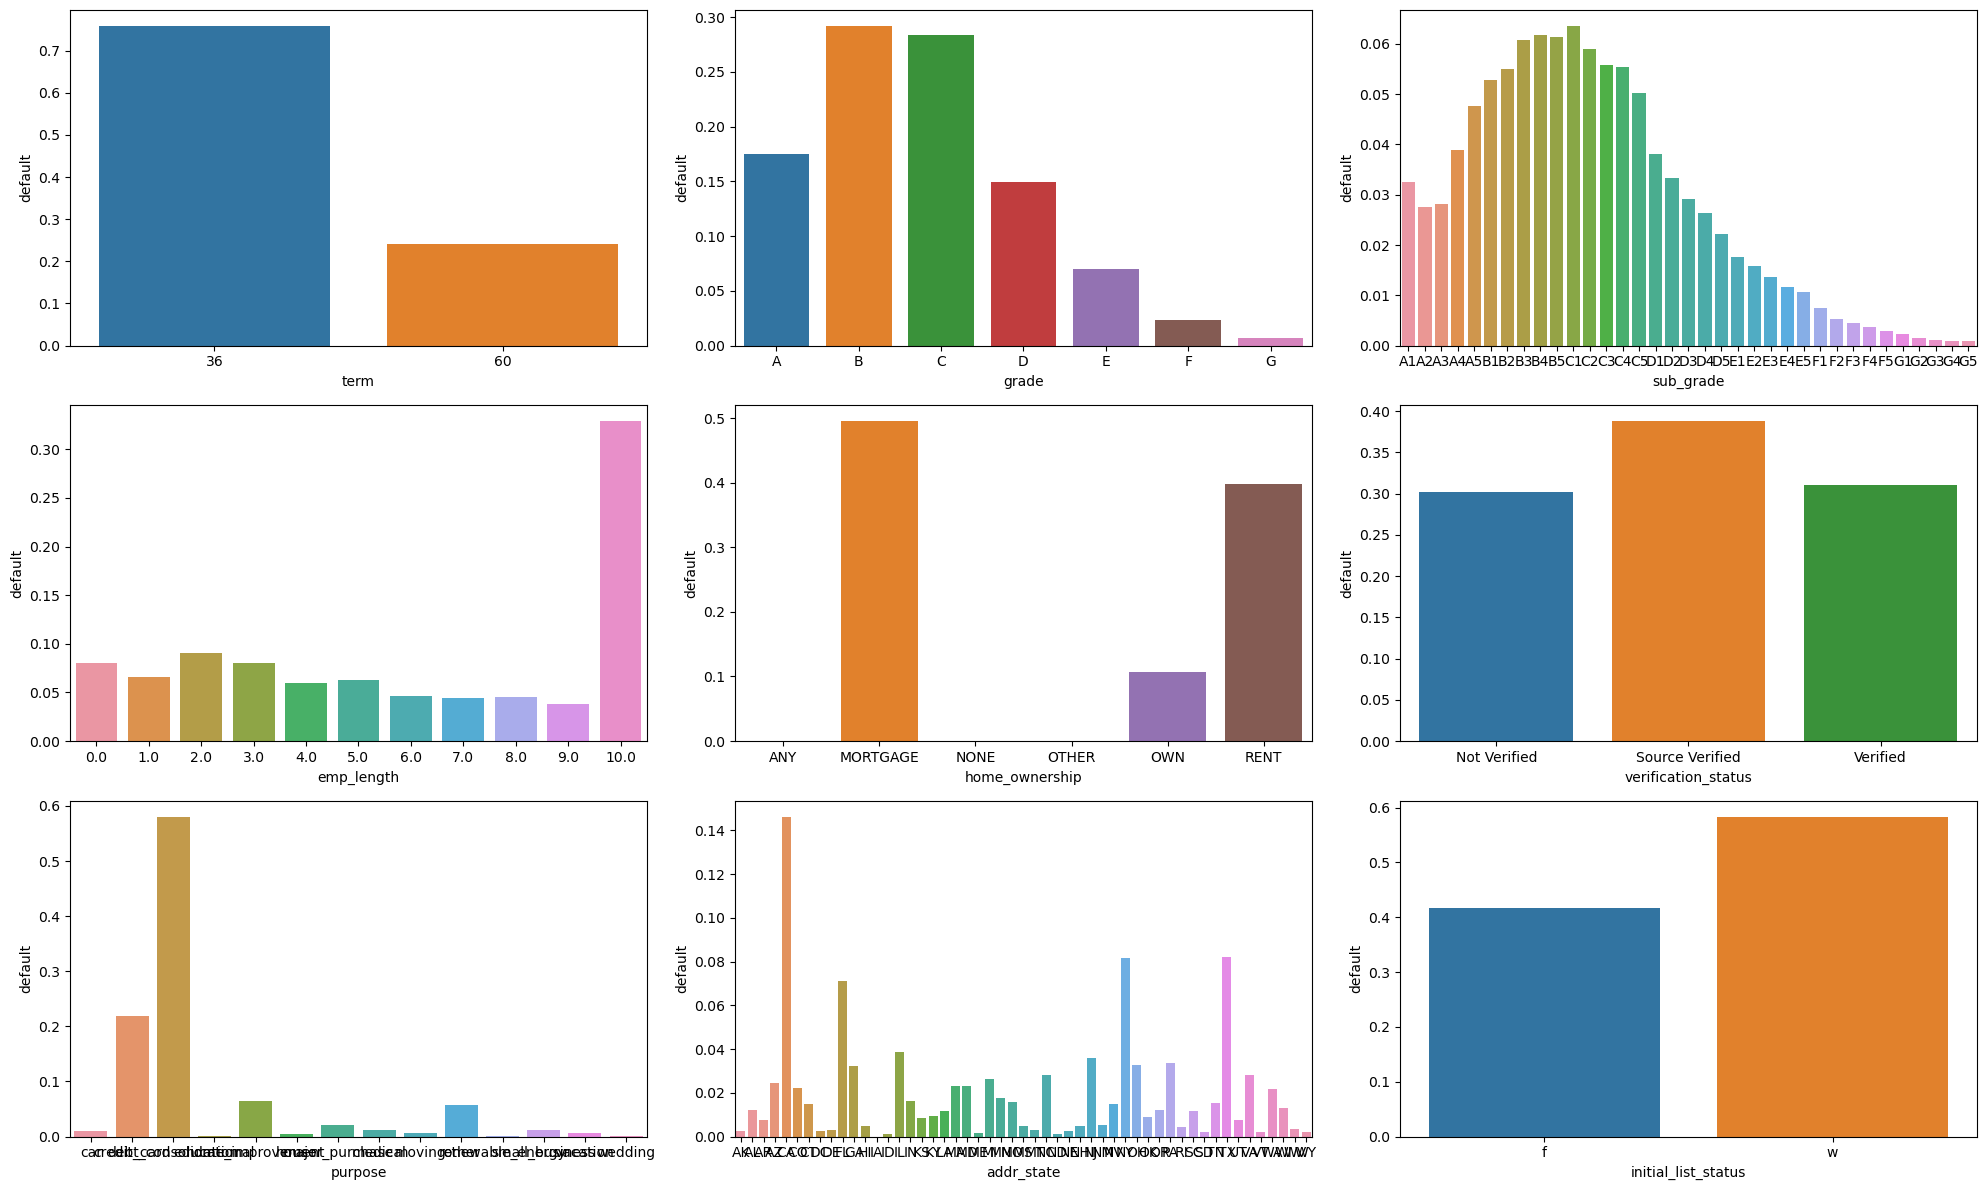

In [10]:
fig, axs = plt.subplots(3,3, figsize=(20,12))

for i in range(len(cat_vars)):
    df = loans_df[cat_vars + ["default"]].group_by(cat_vars[i]).agg(pl.col("default").len())
    df = df.with_columns(pl.col("default") / pl.sum("default")).to_pandas().sort_values(by=cat_vars[i])
    r = i // 3
    c = i % 3
    sns.barplot(data=df, x=cat_vars[i], y="default", ax=axs[r][c])

fig.tight_layout()

From this plot we see that all remaining features have some relationship with default. In particular, grade and sub-grade seemed to exhibit a nonlinear relationship, which may help the nonlinear models make better predictions.

### Numerical Variables 

We now examine the numerical features and how they relate to default. 

In [11]:
num_vars = loans_df.select(cs.by_dtype(pl.NUMERIC_DTYPES)).columns

loans_df[num_vars].describe().to_pandas().T

,0,1,2,3,4,5,6,7,8
statistic,count,null_count,mean,std,min,25%,50%,75%,max
id,1345310.0,0.0,56344994.067618,38361138.294607,54734.0,20027732.0,57734670.0,84546060.0,145636374.0
loan_amnt,1345310.0,0.0,14419.972014,8717.050787,500.0,8000.0,12000.0,20000.0,40000.0
term,1345310.0,0.0,41.790196,10.268321,36.0,36.0,36.0,36.0,60.0
int_rate,1345310.0,0.0,13.239619,4.768716,5.31,9.75,12.74,15.99,30.99
installment,1345310.0,0.0,438.075533,261.512604,4.93,248.48,375.43,580.73,1719.83
emp_length,1266799.0,78511.0,5.965873,3.691166,0.0,2.0,6.0,10.0,10.0
annual_inc,1345310.0,0.0,76247.636414,69925.098427,0.0,45780.0,65000.0,90000.0,10999200.0
dti,1344936.0,374.0,18.282667,11.160446,-1.0,11.79,17.61,24.06,999.0
delinq_2yrs,1345310.0,0.0,0.317794,0.877992,0.0,0.0,0.0,0.0,39.0


A few observations: 

- We will remove any null rows as these are small in number compared with the full size of the data. 
- The `annual_inc` and `revol_bal` features are heavily skewed from their respective medians, so we will apply a log transform before we normalize. 

In [12]:
loans_df = loans_df.drop("id")

loans_df = loans_df.drop_nulls()

## log transforms
loans_df = loans_df.with_columns(
    log_annual_inc = pl.col("annual_inc").map_elements(lambda x: np.log(x+1)),
    log_revol_bal = pl.col("revol_bal").map_elements(lambda x: np.log(x+1))
)

## drop unneccessary columns
loans_df = loans_df.drop(["annual_inc", "revol_bal"])

### Encoding 

We are now ready to encode our categorical variables.

To encode, we will use a mix of label and OneHotEncoding. We will use label encoding for `grade` and `subgrade`. For the others, we will reduce the categories to only the most prominent and then encode. 

In [13]:
## label encode
loans_df = loans_df.with_columns(
    pl.col("grade").rank('dense').cast(pl.Int64).alias('grade_encoded'),
    pl.col("sub_grade").rank('dense').cast(pl.Int64).alias('sub_grade_encoded')
)

Here we reduce categories of `home_ownership`, `purpose` and `addr_state`, and then one-hot encode. 

In [14]:
## reduce home ownership categories
loans_df = loans_df.filter(pl.col("home_ownership").is_in(["RENT", "OWN", "MORTGAGE"]))

In [15]:
## reduce purpose categories by combining low count cats
low_count_categories = loans_df["purpose"].value_counts()\
                       .sort(by="count", descending=True)["purpose", 4:]

loans_df = loans_df.with_columns(
    pl.when(pl.col('purpose').is_in(low_count_categories))
    .then(pl.lit("other"))
    .otherwise(pl.col("purpose")).name.keep()
)

In [16]:
## reduce addr_state categories by combining low count cats
low_count_categories = loans_df["addr_state"].value_counts()\
                       .sort(by="count", descending=True)["addr_state", 10:]

loans_df = loans_df.with_columns(
    pl.when(pl.col('addr_state').is_in(low_count_categories))
    .then(pl.lit("other"))
    .otherwise(pl.col("addr_state")).name.keep()
)

In [17]:
## one hot encode the variables
one_hot_vars = ["home_ownership", "purpose", "addr_state", 
                "verification_status", "initial_list_status"]
loans_df = loans_df.to_dummies(columns=one_hot_vars)

In [18]:
## drop the features that are no longer needed
drop_list = ["grade", "sub_grade"]
df = loans_df.drop(drop_list)

In [19]:
df.glimpse()

Rows: 1187855
Columns: 50
$ loan_amnt                           <f64> 3600.0, 24700.0, 20000.0, 10400.0, 11950.0, 20000.0, 20000.0, 10000.0, 8000.0, 1400.0
$ term                                <i64> 36, 36, 60, 60, 36, 36, 36, 36, 36, 36
$ int_rate                            <f64> 13.99, 11.99, 10.78, 22.45, 13.44, 9.17, 8.49, 6.49, 11.48, 12.88
$ installment                         <f64> 123.03, 820.28, 432.66, 289.91, 405.18, 637.58, 631.26, 306.45, 263.74, 47.1
$ emp_length                          <i64> 10, 10, 10, 3, 4, 10, 10, 6, 10, 3
$ home_ownership_MORTGAGE              <u8> 1, 1, 1, 1, 0, 1, 1, 0, 1, 1
$ home_ownership_OWN                   <u8> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
$ home_ownership_RENT                  <u8> 0, 0, 0, 0, 1, 0, 0, 1, 0, 0
$ verification_status_Not Verified     <u8> 1, 1, 1, 0, 0, 1, 1, 1, 1, 1
$ verification_status_Source Verified  <u8> 0, 0, 0, 1, 1, 0, 0, 0, 0, 0
$ verification_status_Verified         <u8> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
$ purpose_cre

We now have a clean dataset that is ready for ML models. 

## Models

We now split the data into train-test sets and apply our ML models. 

### Splitting

In [20]:
X = df.to_pandas()
y = X.pop("default")

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    shuffle=True,
                                                    stratify=y,
                                                    test_size=0.2)

### Normalization 

We now normalize the training set and fit the scaling to the test set. 

In [21]:
scaling_cols = ["loan_amnt", "int_rate", "installment", "dti",
                "fico_range_low", "fico_range_high", "open_acc",
                "pub_rec", "revol_util", "total_acc", "last_pymnt_amnt",
                "acc_open_past_24mths", "avg_cur_bal", "bc_open_to_buy",
                "bc_util", "mo_sin_old_rev_tl_op", "num_actv_rev_tl",
                "log_annual_inc", "log_revol_bal"]

scalers = []
for col in scaling_cols:
    scaler = StandardScaler()
    X_train[col] = scaler.fit_transform(X_train[[col]])
    X_test[col] = scaler.transform(X_test[[col]])
    scalers.append((col, scaler))

### Model Evaluation 

Due to the imbalanced nature of our `default` feature, we must carefully consider our metric. As false negatives (borrowers who default but who were predicted to not default) are much more costly to investors than false positives (borrowers who don't default but who were predicted to default), we will make use of recall as a metric, as well as the area under the ROC curve. 

### Model Selection 

We will use 10-fold cross validation on a large number of models, and then select the best performing model for hyperparameter tuning. 

In [22]:
scoring = 'accuracy'
models = []

## baseline models 
models.append(('LR', LogisticRegression(max_iter=100000)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

## ensemble models 
models.append(('RF', RandomForestClassifier()))

## boosting models 
models.append(('GBM', GradientBoostingClassifier()))
models.append(('AB', AdaBoostClassifier()))

## neural networks
models.append(('NN1', MLPClassifier()))

In [ ]:
results = []
names = []

for name, model in models :
    kfold = StratifiedKFold(n_splits=10)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print(f"{name}: {cv_results.mean()} ({cv_results.std()})")